# Doc2Vec

## Reading Data from CSV

In [ ]:
import pandas as pd

csv_file = "arxiv.csv"
data = pd.read_csv(csv_file, sep=";")

## Text cleaning
1. Lowercasing - we convert all text to lowercase for uniformity,
2. Remove punctuation - we eliminate unnecessary punkctuation marks
3. Remove numbers - we are modelling topics from the text so numbers do not have any meaning in our case.
4. Remove stopwords - stop words are very common words that carry no meaning or less meaning compared to other words. If we remove the words that are less commonly used, we can focus on the important words instead.
6. Lemmatization - we extract the semantic root of a word (lemma) by considering the vocabulary and connections between the meanings of various words

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

! We combine 'Title' and 'Summary' into a single text field

In [ ]:
def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Tokenization
    tokens = word_tokenize(text)
    # Remove punctuation, numbers and stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    return lemmatized_tokens

In [ ]:
data['processed_text'] = data.apply(lambda row: preprocess_text(row['Title'] + " " + row['Summary']), axis=1)

In [ ]:
data.head(10)

,ID,Title,Summary,Published,PDF Link,Flesch reading ease,Number of words,processed_text
0,http://arxiv.org/abs/cs/0002002v1,Uniform semantic treatment of default and auto...,We revisit the issue of connections between tw...,2000-02-03T21:44:57Z,http://arxiv.org/pdf/cs/0002002v1,26.30,195,"[uniform, semantic, treatment, default, autoep..."
1,http://arxiv.org/abs/cs/0002003v1,On the accuracy and running time of GSAT,Randomized algorithms for deciding satisfiabil...,2000-02-04T12:53:57Z,http://arxiv.org/pdf/cs/0002003v1,35.47,188,"[accuracy, running, time, gsat, randomized, al..."
2,http://arxiv.org/abs/cs/0002009v1,Syntactic Autonomy: Why There is no Autonomy w...,Two different types of agency are discussed ba...,2000-02-16T18:09:20Z,http://arxiv.org/pdf/cs/0002009v1,22.85,160,"[syntactic, autonomy, autonomy, without, symbo..."
3,http://arxiv.org/abs/cs/0003008v1,Consistency Management of Normal Logic Program...,This paper presents a method of computing a re...,2000-03-05T10:29:03Z,http://arxiv.org/pdf/cs/0003008v1,45.69,127,"[consistency, management, normal, logic, progr..."
4,http://arxiv.org/abs/cs/0003016v1,Abductive and Consistency-Based Diagnosis Revi...,Diagnostic reasoning has been characterized lo...,2000-03-07T11:39:53Z,http://arxiv.org/pdf/cs/0003016v1,17.30,110,"[abductive, diagnosis, revisited, modeling, pe..."
5,http://arxiv.org/abs/cs/0003020v2,ACLP: Integrating Abduction and Constraint Sol...,ACLP is a system which combines abductive reas...,2000-03-07T22:47:13Z,http://arxiv.org/pdf/cs/0003020v2,21.33,171,"[aclp, integrating, abduction, constraint, sol..."
6,http://arxiv.org/abs/cs/0003021v1,Relevance Sensitive Non-Monotonic Inference on...,We present a method for relevance sensitive no...,2000-03-08T03:03:36Z,http://arxiv.org/pdf/cs/0003021v1,0.15,143,"[relevance, sensitive, inference, belief, sequ..."
7,http://arxiv.org/abs/cs/0003024v1,A Compiler for Ordered Logic Programs,"This paper describes a system, called PLP, for...",2000-03-08T10:15:51Z,http://arxiv.org/pdf/cs/0003024v1,38.66,120,"[compiler, ordered, logic, program, paper, des..."
8,http://arxiv.org/abs/cs/0003028v1,Logic Programs with Compiled Preferences,We describe an approach for compiling preferen...,2000-03-08T14:09:56Z,http://arxiv.org/pdf/cs/0003028v1,37.03,179,"[logic, program, compiled, preference, describ..."
9,http://arxiv.org/abs/cs/0003031v1,Optimal Belief Revision,We propose a new approach to belief revision t...,2000-03-08T15:54:50Z,http://arxiv.org/pdf/cs/0003031v1,31.92,178,"[optimal, belief, revision, propose, new, appr..."


## Tagging Documents and Traning Doc2Vec
Once we have the processed text, we need to tag the documents. For this purpose, we will use ID column. Let's check if all the articles have the same patter of ID:

`http://arxiv.org/abs/cs/{uniqueId}`

In [ ]:
import re

total_rows = len(data)

pattern = r"http://arxiv.org/abs/cs/(\w+)"

matching_rows = 0
non_matching_rows = []
for index, row in data.iterrows():
  id = row['ID']
  if re.match(pattern, str(id)):
    matching_rows += 1
  else:
    non_matching_rows.append(index)

print(f"Total number of rows: {total_rows}")
print(f"Number of rows with matching ID pattern: {matching_rows}")
print(f"Example of non-matching ID pattern row: {data.loc[non_matching_rows[0]]['ID']}")

Total number of rows: 34575
Number of rows with matching ID pattern: 477
Example of non-matching ID pattern row: http://arxiv.org/abs/0704.2010v2


We see that we cannot use part of ID as unique TAG. So we will use number of row as id for text and train the Doc2Vec model.

In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

tagged_data = [TaggedDocument(words=row['processed_text'], tags=[str(index)]) for index, row in data.iterrows()]

model = Doc2Vec(vector_size=100, window=5, min_count=1, workers=4, epochs=20)
model.build_vocab(tagged_data)
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

## Clustering Document Vectors
Once the model is trained, extract document vectors and apply clustering. We will use K-Means for simple clustering

In [ ]:
from sklearn.cluster import KMeans
import numpy as np

vectors = [model.dv[str(index)] for index, row in data.iterrows()]

num_clusters = 10
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(vectors)

data['cluster'] = kmeans.labels_

### Visualizing the Clusters

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy

vectors_np = np.array(vectors)
tsne_model = TSNE(n_components=2, random_state=0, verbose=1)
reduced_vecs = tsne_model.fit_transform(vectors_np)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 34575 samples in 0.002s...
[t-SNE] Computed neighbors for 34575 samples in 19.458s...
[t-SNE] Computed conditional probabilities for sample 1000 / 34575
[t-SNE] Computed conditional probabilities for sample 2000 / 34575
[t-SNE] Computed conditional probabilities for sample 3000 / 34575
[t-SNE] Computed conditional probabilities for sample 4000 / 34575
[t-SNE] Computed conditional probabilities for sample 5000 / 34575
[t-SNE] Computed conditional probabilities for sample 6000 / 34575
[t-SNE] Computed conditional probabilities for sample 7000 / 34575
[t-SNE] Computed conditional probabilities for sample 8000 / 34575
[t-SNE] Computed conditional probabilities for sample 9000 / 34575
[t-SNE] Computed conditional probabilities for sample 10000 / 34575
[t-SNE] Computed conditional probabilities for sample 11000 / 34575
[t-SNE] Computed conditional probabilities for sample 12000 / 34575
[t-SNE] Computed conditional probabilities for sa

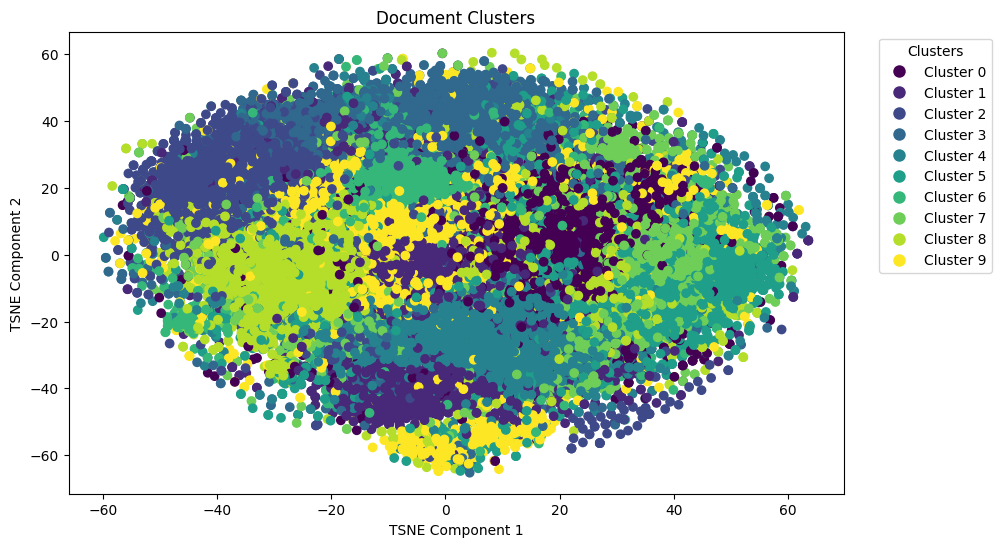

In [ ]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(reduced_vecs[:, 0], reduced_vecs[:, 1], c=kmeans.labels_, cmap='viridis', marker='o')
unique_clusters = np.unique(kmeans.labels_)
handles = []
for cluster in unique_clusters:
    handle = plt.Line2D([], [], marker='o', color='w', label=f'Cluster {cluster}',
                         markerfacecolor=scatter.cmap(scatter.norm(cluster)), markersize=10)
    handles.append(handle)

plt.legend(handles=handles, title="Clusters", loc='upper right', bbox_to_anchor=(1.2, 1))

plt.title("Document Clusters")
plt.xlabel("TSNE Component 1")
plt.ylabel("TSNE Component 2")

plt.show()

### Example of clustered texts

In [ ]:
cluster_number = 0

cluster_docs = data[data['cluster'] == cluster_number]

for index, row in cluster_docs.head(5).iterrows():
    print(f"Document ID: {row['ID']}")
    print(f"Title: {row['Title']}")
    print(f"Summary: {row['Summary']}")
    print(f"Cluster: {row['cluster']}")
    print("-" * 80)

Document ID: http://arxiv.org/abs/cs/0002002v1
Title: Uniform semantic treatment of default and autoepistemic logics
Summary: We revisit the issue of connections between two leading formalisms in nonmonotonic reasoning: autoepistemic logic and default logic. For each logic we develop a comprehensive semantic framework based on the notion of a belief pair. The set of all belief pairs together with the so called knowledge ordering forms a complete lattice. For each logic, we introduce several semantics by means of fixpoints of operators on the lattice of belief pairs. Our results elucidate an underlying isomorphism of the respective semantic constructions. In particular, we show that the interpretation of defaults as modal formulas proposed by Konolige allows us to represent all semantics for default logic in terms of the corresponding semantics for autoepistemic logic. Thus, our results conclusively establish that default logic can indeed be viewed as a fragment of autoepistemic logic. 